In [98]:
import pandas as pd
import os
from rxnmapper import RXNMapper
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem

In [148]:
path = '/home/ruard/Documents/datasets/MA_reaxys_export/'
dfs = []
for name in ['MA_1.tsv', 'MA_2.tsv', 'MA_3.tsv', 'MA_4.tsv', 'MA_5.tsv']:
    dfs.append(pd.read_csv(os.path.join(path, name), sep='\t'))
    
df = pd.concat(dfs)
print(len(df))

df.columns

33452


Index(['Reaction ID', 'Reaction: Links to Reaxys', 'Data Count',
       'Number of Reaction Details', 'Reaction Rank', 'Record Type',
       'Reactant', 'Product', 'Bin', 'Reaction',
       'Reaction Details: Reaction Classification', 'Example label',
       'Example title', 'Fulltext of reaction', 'Number of Reaction Steps',
       'Multi-step Scheme', 'Multi-step Details', 'Number of Stages',
       'Solid Phase', 'Time (Reaction Details) [h]',
       'Temperature (Reaction Details) [C]',
       'Pressure (Reaction Details) [Torr]', 'pH-Value (Reaction Details)',
       'Other Conditions', 'Reaction Type', 'Subject Studied',
       'Prototype Reaction', 'Named Reaction',
       'Type of reaction description (Reaction Details)', 'Location',
       'Comment (Reaction Details)', 'Product.1', 'Yield', 'Yield (numerical)',
       'Yield (optical)', 'Stage Reactant', 'Reagent', 'Catalyst',
       'Solvent (Reaction Details)', 'References', 'Links to Reaxys',
       'Unnamed: 41'],
      dt

In [149]:
# no multistep reactions
df = df[df['Multi-step Details'].isnull()]
print(len(df))

# no NaN reactions 
df = df[~df['Reaction'].isna()]
print(len(df))

# no duplicate reaction smiles
df = df.drop_duplicates(subset=['Reaction'])
print(len(df))

33446
33317
20002


In [150]:
# filter reactions with multiple unsaturated carbons
SMARTS = Chem.MolFromSmarts('[#6:1]=[#6:2][#6:3](=[O:4])') # C=CC(=O)C

'[#6:1]=[#6:2].[#6:3]=[#6:4][#6:5]=[#6:6]>>[#6:1]1[#6:2][#6:3][#6:4]=[#6:5][#6:6]1'

filtered_reaction_ids = []
for reaction, reaction_id in zip(df['Reaction'].values, df['Reaction ID'].values):
    reactants, products = reaction.split('>>')
    if len(reactants.split('.')) == 2 and len(products.split('.')) == 1: 
        reactant1, reactant2 = reactants.split('.')
        reactant1 = Chem.MolFromSmiles(reactant1)
        reactant2 = Chem.MolFromSmiles(reactant2)
        
        if reactant1 is not None and reactant2 is not None:
            if len(reactant1.GetSubstructMatches(SMARTS)) >= 2 or len(reactant2.GetSubstructMatches(SMARTS)) >= 2:
                filtered_reaction_ids.append(reaction_id)

df = df[df['Reaction ID'].isin(filtered_reaction_ids)]
print(len(df))

1210


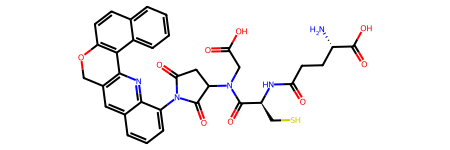

In [162]:
# see if there could be a regioselective thing
reaction_smarts = AllChem.ReactionFromSmarts(
    "[#6:1]=[#6:2][#6:3](=[O:4]).[N,S,n,s:5]>>[N,S,n,s:5][#6:1]-[#6:2][#6:3](=[O:4])"
)

def simulate_reaction(substrates):
    products = []
    products += reaction_smarts.RunReactants(substrates)
    substrates = [substrates[1], substrates[0]]
    products += reaction_smarts.RunReactants(substrates)
    
    products = [Chem.MolToSmiles(product[0]) for product in products]
    products = list(set(products))
    products = [Chem.MolFromSmiles(product) for product in products]
    return list(filter(lambda x: x is not None, products))

filtered_reaction_ids = []
idx = 0
for reaction, reaction_id in zip(df['Reaction'].values, df['Reaction ID'].values):
    reactants, products = reaction.split('>>')
    reactant1, reactant2 = reactants.split('.')
    reactant1 = Chem.MolFromSmiles(reactant1)
    reactant2 = Chem.MolFromSmiles(reactant2)

    out = simulate_reaction([reactant1, reactant2])
    if len(out) >= 2:
        filtered_reaction_ids.append(reaction_id)
        
df = df[df['Reaction ID'].isin(filtered_reaction_ids)]
print(len(df))

In [153]:
# filter out reaction where product has 30+ heavy atoms

filtered_reaction_ids = []
idx = 0
for reaction, reaction_id in zip(df['Reaction'].values, df['Reaction ID'].values):
    reactants, products = reaction.split('>>')
    product = Chem.MolFromSmiles(products)
    print(reaction_id, product.GetNumHeavyAtoms())
    if product.GetNumHeavyAtoms() < 50:
        filtered_reaction_ids.append(reaction_id)
    
df = df[df['Reaction ID'].isin(filtered_reaction_ids)]
print(len(df))

38172024 22
40520295 27
40520296 27
40520298 25
40520299 25
40520303 26
40520347 25
40520348 26
40520349 26
40520350 26
40520351 26
40520352 26
40520353 26
40520354 26
40520355 26
40520356 27
38611317 30
40520294 27
40520300 29
40520301 30
40520302 24
40520357 27
58503295 35
59231343 25
55135233 18
58503291 34
39994498 22
51576731 43
51576732 46
51576733 45
52827702 25
58503294 34
5051767 30
53535491 26
53535492 26
53535493 27
53535494 29
53535496 27
53535497 26
53535498 26
53535499 26
53535500 27
53535501 26
53535502 26
53535503 27
53535504 26
53535505 26
53535506 26
53535508 29
53535509 25
53535511 25
53535512 25
58503293 31
5068180 29
5061457 31
55647174 23
10135713 19
11061567 30
39994499 24
39994501 25
39994503 22
39994505 28
39994511 27
39994513 24
39994514 31
39994516 30
39994518 30
39994520 31
39994522 31
39994524 29
39994526 25
39994530 29
39994532 31
39994534 28
39994536 28
39994538 28
39994540 30
39994542 25
39994545 24
39994547 22
39994550 31
39994552 35
39994554 28
3999455

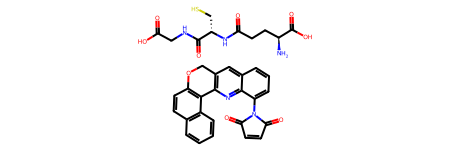

In [155]:
# do something further with this